# Batch Normalization
:label:`ch_batch_norm_cpu`

This section talks about scheduling the batch normalization computation defined in :numref:`ch_batch_norm` on CPU.

## Setup


In [1]:
%matplotlib inline
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te
from tvm import topi

# target = 'llvm -mcpu=skylake-avx512'
target = 'llvm'

## Schedule

We first review the default scheduling of batch normalization and its IR, as shown in :numref:`ch_batch_norm`.


In [2]:
# a tuple of channel and input height/width
size = (32, 28)

def default_bn(size):
    c, n = size[:]
    X, Mean, Var, Gamma, Beta, Y = d2ltvm.batch_norm(c, n)
    sch = te.create_schedule(Y.op)
    return sch, (X, Mean, Var, Gamma, Beta, Y)

sch, args = default_bn(size)
print(tvm.lower(sch, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer((32, 28, 28), "float32"), Mean: T.Buffer((32, 1, 1), "float32"), Var: T.Buffer((32, 1, 1), "float32"), Gamma: T.Buffer((32, 1, 1), "float32"), Beta: T.Buffer((32, 1, 1), "float32"), T_add: T.Buffer((32, 28, 28), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        T_subtract = T.allocate([25088], "float32", "global")
        T_add_1 = T.allocate([32], "float32", "global")
        T_subtract_1 = T.Buffer((25088,), data=T_subtract)
        for ax0, ax1, ax2 in T.grid(32, 28, 28):
            cse_var_1: T.int32 = ax0 * 784 + ax1 * 28 + ax2
            X_1 = T.Buffer((25088,), data=X.data)
            Mean_1 = T.Buffer((32,), data=Mean.data)
            T_subtract_1[cse_var_1] = X_1[cse_var_1] - Mean_1[ax0]
        T_add_2 = T.Buffer((32,), data=T_add_1)
        for ax0 in range(32):
            

We can easily tell that the multiple stages of the computation can be fused injectively together. Like we have done in :numref:`ch_pooling_cpu`, `te.schedule.AutoInlineInjective(sch)` is used for it. 
Essentially, `AutoInlineInjective` traverses the stages of the schedule and fuses all stages that are fusable injectively.
The resulting stage is a three-level nested loop of channel, input height, and input width.

In addition, we can fuse the first two axes into one and parallelize it in multi-thread. We can also vectorize the innermost axis.
The optimized scheduling scheme looks a lot like the scheduling of `max_pooling` in :numref:`ch_pooling_cpu`.


In [3]:

def optimized_bn(size):
    sch, (X, Mean, Var, Gamma, Beta, Y) = default_bn(size)
    te.schedule.AutoInlineInjective(sch)
    c, h, w = Y.op.axis[0:3]
    fused = sch[Y].fuse(c, h)
    sch[Y].parallel(fused)
    sch[Y].vectorize(w)
    return sch, (X, Mean, Var, Gamma, Beta, Y)

sch, args = optimized_bn(size)
print(tvm.lower(sch, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer((32, 28, 28), "float32"), Mean: T.Buffer((32, 1, 1), "float32"), Var: T.Buffer((32, 1, 1), "float32"), Gamma: T.Buffer((32, 1, 1), "float32"), Beta: T.Buffer((32, 1, 1), "float32"), T_add: T.Buffer((32, 28, 28), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0_ax1_fused in T.parallel(896):
            cse_var_2: T.int32 = ax0_ax1_fused // 28
            cse_var_1: T.int32 = ax0_ax1_fused * 28
            T_add_1 = T.Buffer((25088,), data=T_add.data)
            X_1 = T.Buffer((25088,), data=X.data)
            Mean_1 = T.Buffer((32,), data=Mean.data)
            Var_1 = T.Buffer((32,), data=Var.data)
            Gamma_1 = T.Buffer((32,), data=Gamma.data)
            Beta_1 = T.Buffer((32,), data=Beta.data)
            T_add_1[cse_var_1:cse_var_1 + 28] = (X_1[cse_var_1:cse_var_1 + 

## Benchmarking

First, we define the method to benchmark batch normalization of TVM as usual.


In [4]:
# Save to the d2ltvm package.
def bench_bn_tvm(func, sizes, target):
    """Benchmark batch normalization in TVM

    func : the scheduling method
    sizes : the data size list, each of which is a (channel, input_hw) tuple
    target : the TVM target, e.g. llvm or cuda
    """
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(data, mean, var, gamma, beta, out).mean * nrepeats
    times = []
    for size in sizes:
        sch, args = func(size)
        mod = tvm.build(sch, args, target)
        ctx = tvm.device(target, 0)
        data, mean, var, gamma, beta, out = d2ltvm.get_bn_data(size[0], size[1], 
                                                               lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return np.array(times)

Then, we use MXNet as the baseline, and define the method to benchmark its performance.


In [5]:
# Save to the d2ltvm package.
def bn_timer_mxnet(c, n, ctx):
    """Benchmark batch normalization in MXNet

    c : channels
    n : input width and height
    ctx : compute ctx, e.g., cpu or gpu
    """
    timer = timeit.Timer(
        setup='import d2ltvm\n'
        'import mxnet as mx\n'
        'c, n = %d, %d\n'
        'data, mean, var, gamma, beta, out = d2ltvm.get_bn_data_mxnet(\n'
        '    c, n, "%s")'%(c, n, ctx),
        stmt='d2ltvm.batch_norm_mxnet(data, mean, var, gamma, beta, out);'
        'out.wait_to_read()')
    return timer.timeit

# Save to the d2ltvm package.
def bench_bn_mxnet(sizes, ctx='cpu'):
    """Return the execution times of MXNet batch norm"""
    return [d2ltvm.bench_workload(bn_timer_mxnet(c, n, ctx))
            for c, n in sizes]

Finally, we define a number of different channel numbers (with the fixed input size $28 \times 28$) to plot the benchmarking results of our baseline, default scheduling and optimized scheduling.


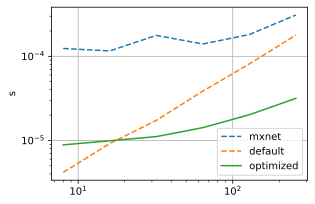

In [6]:
channels = 2**np.arange(3, 9, 1)
# a list of (c, n)
sizes = [(int(c), 28) for c in channels]

mxnet_times = bench_bn_mxnet(sizes)
default_times = bench_bn_tvm(default_bn, sizes, target)
optimized_times = bench_bn_tvm(optimized_bn, sizes, target)

times = [mxnet_times, default_times, optimized_times]
d2ltvm.plot(channels, times, ylabel='s',
            xscale='log', yscale='log',
            legend=['mxnet', 'default', 'optimized'], fmts=['--']*(len(times)-1)+['-'])

From the diagram we can see multiple things.
First, for this kind of small operators, MXNet's execution time is dominated by the function invoking overhead (:numref:`ch_call_overhead`). Second, TVM's invoking overhead is small, making even the default schedule outperforms the MXNet baseline. Third, after fusing stages and doing proper parallelization and vectorization, we can have a much better performance for batch normalization.

## Summary

- Like Pooling, the optimization of batch normalization on CPU is all about stage fusion and parallelization/vectorization.
